In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import time
import json
import numpy as np
from src import dataloader
from models import transformers, engine, configs

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Check if there is GPU(s): {torch.cuda.is_available()}")

Check if there is GPU(s): True


### 4D

In [3]:
Exp_name  = 'test_v2'
data_loader_training, data_loader_validate, data_loader_testing = dataloader.return_data_loaders(configs.data_config_dict, configs.get_train_hyperparameter_config, Exp_name)
model      = transformers.VisionTransformer_V2(configs.SparkMET_4D_config_v2(), img_size=32, num_classes=2,).to(device)
loss_func  = torch.nn.NLLLoss() 
optimizer  = optim.Adam(model.parameters(), 
                        lr = configs.get_train_hyperparameter_config['lr'], 
                        weight_decay = configs.get_train_hyperparameter_config['wd'])

#================================ Summary of Dataset ==================#
number of training samples:   52 | number of training fog cases:   7
number of validation samples: 52 | number of validation fog cases: 7
number of test samples:       52 | number of test fog cases:       7
#======================================================================#


Epoch 001: | Train Loss: 0.8855 | Val Loss: 0.7917 | Time(s): 25.184
Best model Saved! Val Loss: 0.7917
count: 0
Epoch 002: | Train Loss: 0.5122 | Val Loss: 0.4840 | Time(s): 25.355
Best model Saved! Val Loss: 0.4840
count: 0
Epoch 003: | Train Loss: 0.5455 | Val Loss: 0.5304 | Time(s): 25.553
Model is not saved! Current Val Loss: 0.5304
count: 1
Epoch 004: | Train Loss: 0.4227 | Val Loss: 0.5761 | Time(s): 25.007
Model is not saved! Current Val Loss: 0.5761
count: 2
Epoch 005: | Train Loss: 0.5495 | Val Loss: 0.5924 | Time(s): 24.351
Model is not saved! Current Val Loss: 0.5924
count: 3
Epoch 006: | Train Loss: 0.4164 | Val Loss: 0.4983 | Time(s): 25.651
Model is not saved! Current Val Loss: 0.4983
count: 4
Epoch 007: | Train Loss: 0.3731 | Val Loss: 0.4394 | Time(s): 26.967
Best model Saved! Val Loss: 0.4394
count: 0
Epoch 008: | Train Loss: 0.3360 | Val Loss: 0.3808 | Time(s): 24.792
Best model Saved! Val Loss: 0.3808
count: 0
Epoch 009: | Train Loss: 0.3519 | Val Loss: 0.5893 | Tim

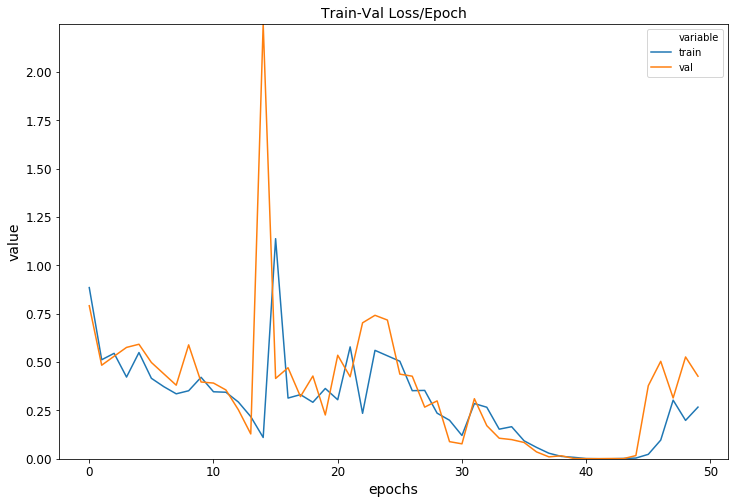

In [5]:
model, loss_stat = engine.train(model, optimizer, loss_func,
                                        configs.get_train_hyperparameter_config,
                                        data_loader_training, 
                                        data_loader_validate, 
                                        Exp_name) 

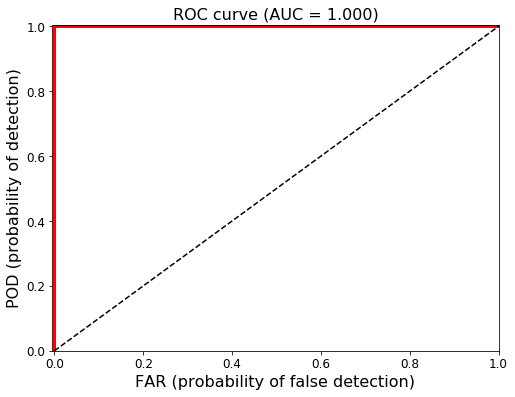

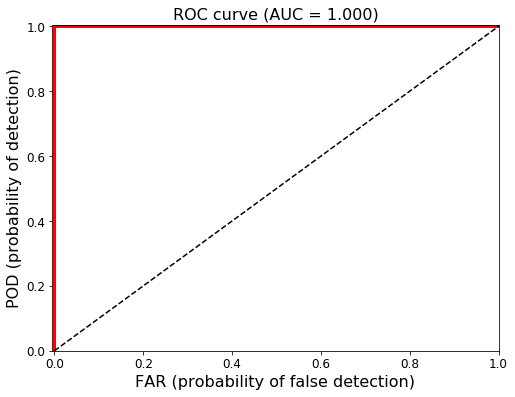

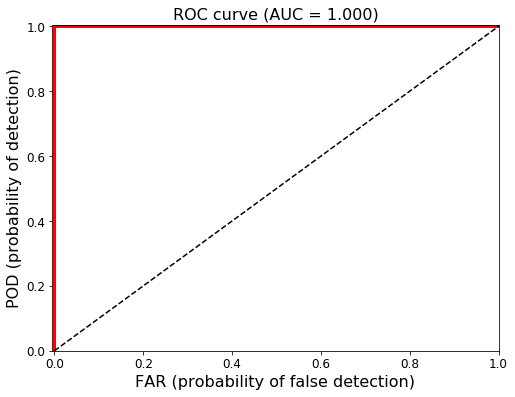

In [6]:
list_predictions, list_inputs, list_raw_attentio_scores, list_attention_gen_maps, list_attention_calc_scores = engine.predict(model, 
                                                data_loader_training, 
                                                data_loader_validate, 
                                                data_loader_testing, 
                                                Exp_name = Exp_name,)

In [5]:
list_raw_attentio_scores[0].shape

(52, 8, 388, 388, 6)

In [32]:
corr_values = list_raw_attentio_scores[0][idx, 7, :, :, 5]
corr_values = (corr_values)/(corr_values.max(axis=1))
for j in range(corr_values.shape[1]): 
    this_col_max = corr_values[:, j].max()
    this_col_min = corr_values[:, j].min()
    corr_values[:, j] = (corr_values[:, j] - this_col_min)/(this_col_max - this_col_min)
corr_values

array([[0.1012432 , 0.09753267, 0.09742086, ..., 0.9111744 , 0.9135283 ,
        0.9214673 ],
       [0.10461526, 0.09777696, 0.09760421, ..., 0.920848  , 0.9252089 ,
        0.9396193 ],
       [0.1088405 , 0.10180774, 0.10157683, ..., 0.9173221 , 0.9217665 ,
        0.9364049 ],
       ...,
       [0.51344764, 0.50280935, 0.5025058 , ..., 0.50257665, 0.5094151 ,
        0.5398966 ],
       [0.5257171 , 0.5130084 , 0.51265126, ..., 0.49726516, 0.50497234,
        0.53838396],
       [0.5576501 , 0.5430561 , 0.5426598 , ..., 0.4777371 , 0.4871131 ,
        0.5243918 ]], dtype=float32)

In [24]:
from sklearn.preprocessing import normalize
corr_values = list_raw_attentio_scores[0][idx, 7, :, :, 5]
data = normalize(corr_values, axis=1, norm='max')
data.min()

0.9946762

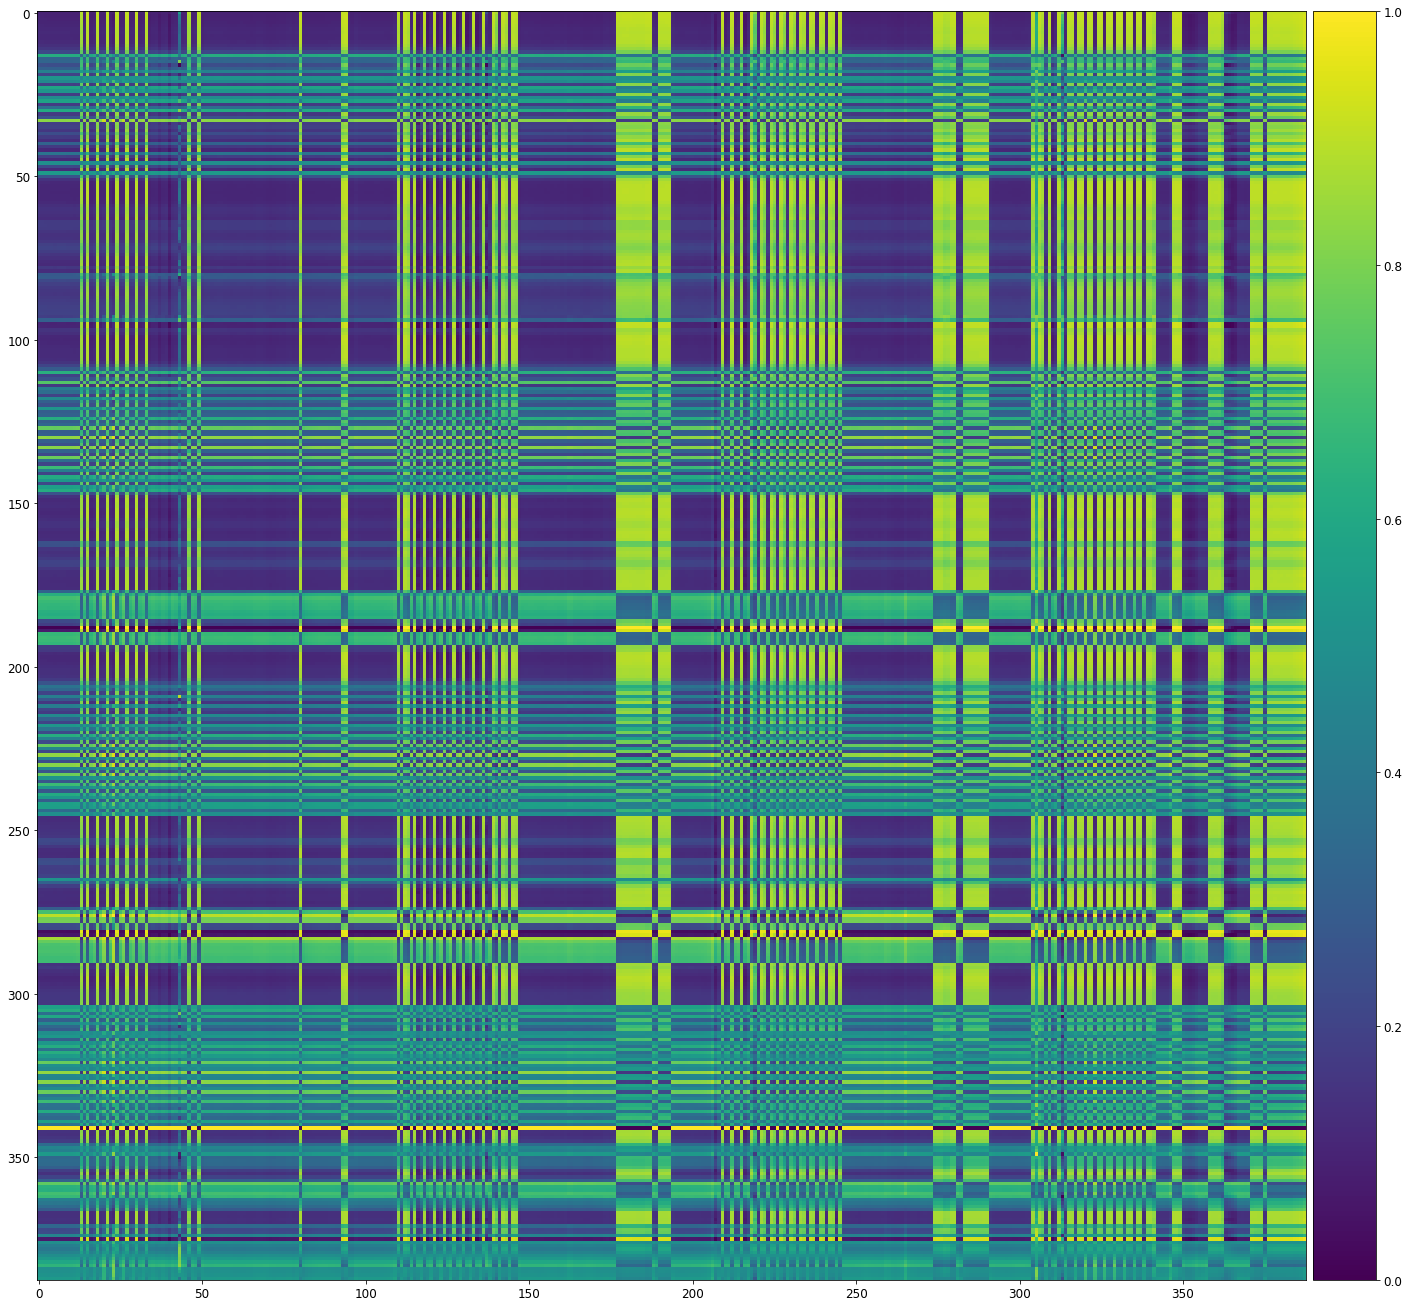

In [33]:
idx = list_predictions[0][list_predictions[0]['date_cycletime'] =='20200115_0000'].index[0]
#corr_values = list_raw_attentio_scores[0][idx, 7, :, :, 5]
#corr_values = (corr_values - corr_values.min(axis=0))/(corr_values.max(axis=0) -  corr_values.min(axis=0))
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize = (24, 24))

vis1 = ax.imshow(corr_values)
#vis1.set_clim(0.002565,0.002570)
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar1 = fig.colorbar(vis1, cax=cax)

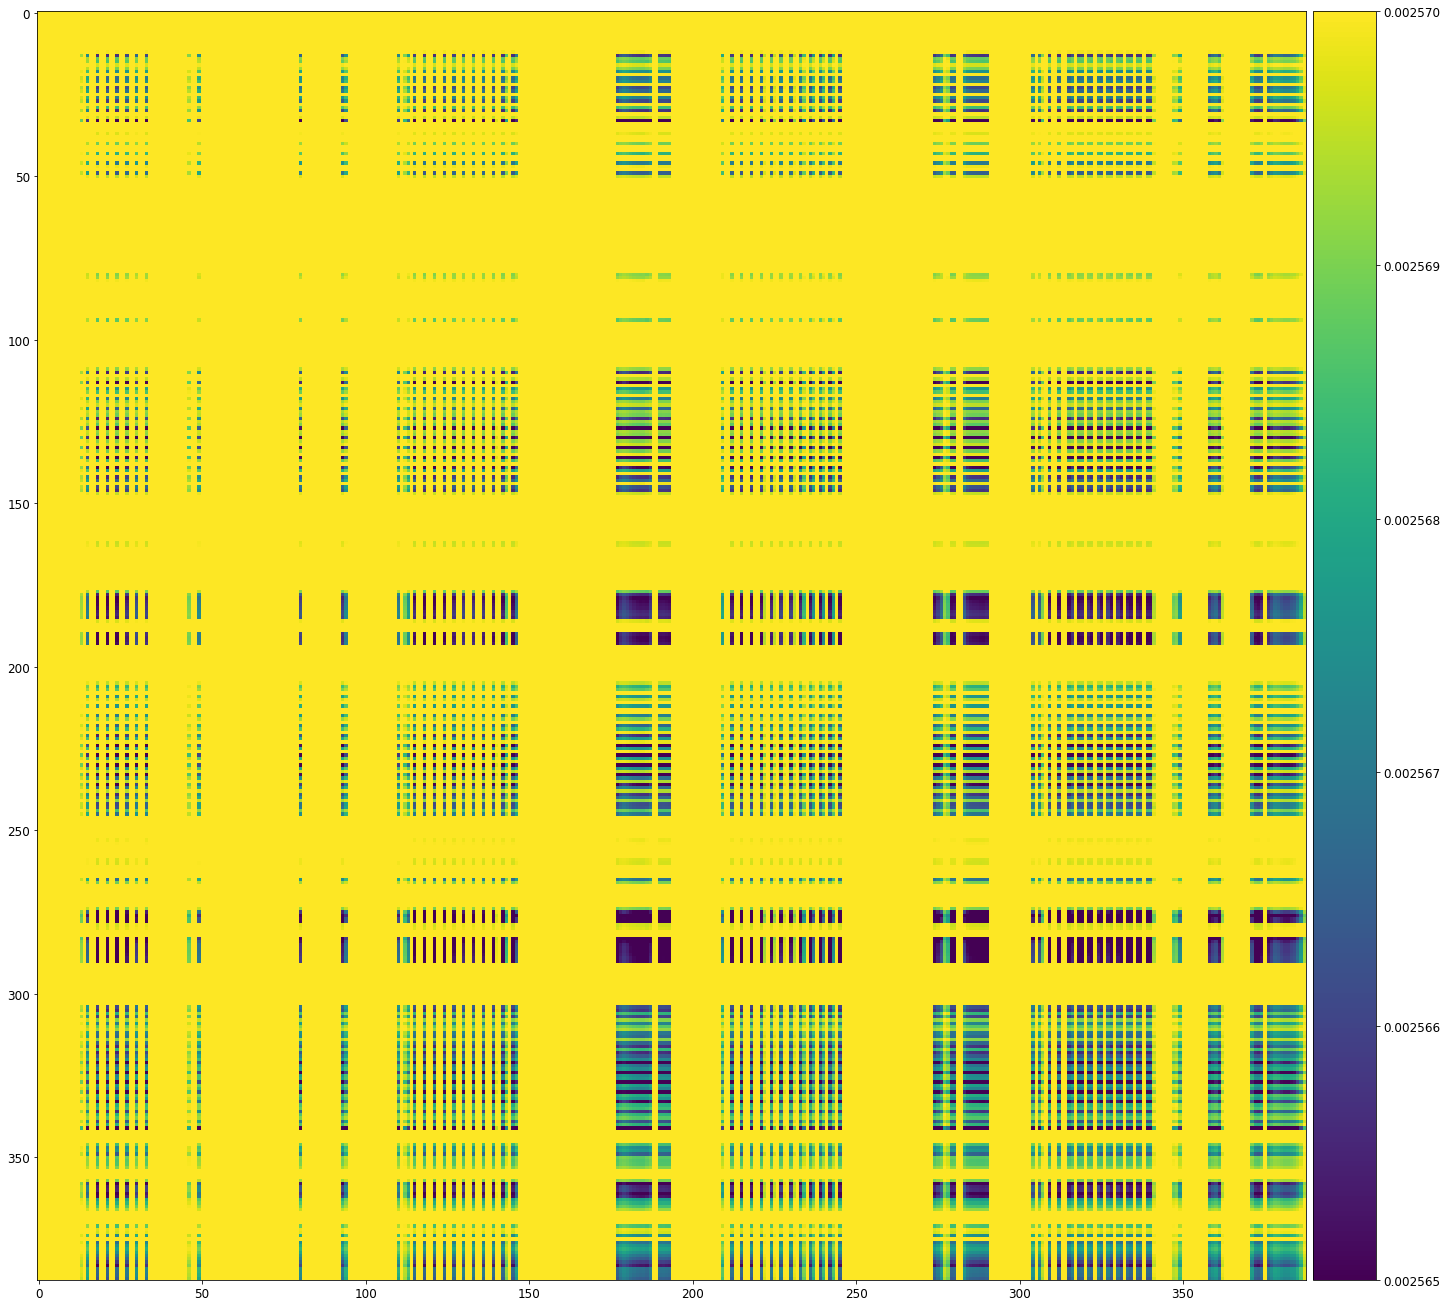

In [16]:
idx = list_predictions[0][list_predictions[0]['date_cycletime'] =='20200115_0000'].index[0]
corr_values = list_raw_attentio_scores[0][idx, 7, :, :, 5]
corr_values = corr_values / corr_values.max(axis=0)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize = (24, 24))

vis1 = ax.imshow(corr_values)
vis1.set_clim(0.002565,0.002570)
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar1 = fig.colorbar(vis1, cax=cax)


In [80]:

def return_variables_corr(attention_scores, date:str, sum_heads: True): 

    idx = list_output[0][list_output[0]['date_cycletime'] ==date].index[0]


    sum_scores = np.zeros(attention_scores.shape[2])
    if sum_heads is True: 
        for head in range(list_attention_maps[0].shape[1]):
            this_head_scores = list_attention_maps[0][idx, head, :, -1]
            sum_scores += this_head_scores

        #[i[0] for i in sorted(enumerate(this_head_scores), key=lambda k: k[1], reverse=True)]
        avg_scores = sum_scores/list_attention_maps[0].shape[1]
        inxs = [i[0] for i in sorted(enumerate(avg_scores), key=lambda k: k[1], reverse=True)]

    ids = [(idx - ((idx//97)*97)) for idx in inxs]
    variables_dict = {}
    for idx in inxs: 
        id = (idx - ((idx//97)*97))
        t = (idx//97)
        if id < 93: 
            variables = configs.NETCDF_PREDICTOR_NAMES['All'][id]
        elif id == 93:
            variables = configs.NETCDF_SST
        elif id == 94:
            variables = configs.NETCDF_TMPDPT
        elif id == 95:
            variables = configs.NETCDF_TMPSST
        elif id == 96:
            variables = configs.NETCDF_DPTSST

        variables_dict[variables] = [idx, t]
    return variables_dict

In [81]:
out_dict = return_variables_corr(list_attention_maps[0], date = '20200115_0000', sum_heads = True)
out_dict

{'VGRD_700mb': [341, 3],
 'UGRD_950mb': [213, 2],
 'UGRD_10maboveground': [304, 3],
 'RH_700mb': [75, 0],
 'Q_725mb': [256, 2],
 'UGRD_925mb': [22, 0],
 'RH_725mb': [268, 2],
 'UGRD_775mb': [331, 3],
 'Q_775mb': [157, 1],
 'Q_750mb': [255, 2],
 'RH_825mb': [361, 3],
 'UGRD_825mb': [325, 3],
 'UGRD_750mb': [334, 3],
 'UGRD_800mb': [328, 3],
 'RH_750mb': [267, 2],
 'UGRD_900mb': [316, 3],
 'Q_800mb': [156, 1],
 'VGRD_725mb': [241, 2],
 'Q_825mb': [349, 3],
 'RH_900mb': [358, 3],
 'UGRD_850mb': [322, 3],
 'TMP_750mb': [10, 0],
 'RH_850mb': [360, 3],
 'RH_800mb': [362, 3],
 'RH_775mb': [72, 0],
 'TMP_775mb': [9, 0],
 'RH_925mb': [357, 3],
 'TMP_950mb': [196, 2],
 'TMP_925mb': [197, 2],
 'RH_950mb': [259, 2],
 'TMP_800mb': [8, 0],
 'Q_700mb': [354, 3],
 'TMP_725mb': [205, 2],
 'TKE_825mb': [327, 3],
 'RH_975mb': [64, 0],
 'TMP_975mb': [195, 2],
 'Q_925mb': [151, 1],
 'VVEL_875mb': [182, 1],
 'VGRD_950mb': [20, 0],
 'Q_975mb': [52, 0],
 'TMP_850mb': [297, 3],
 'TMP_825mb': [7, 0],
 'TKE_700m

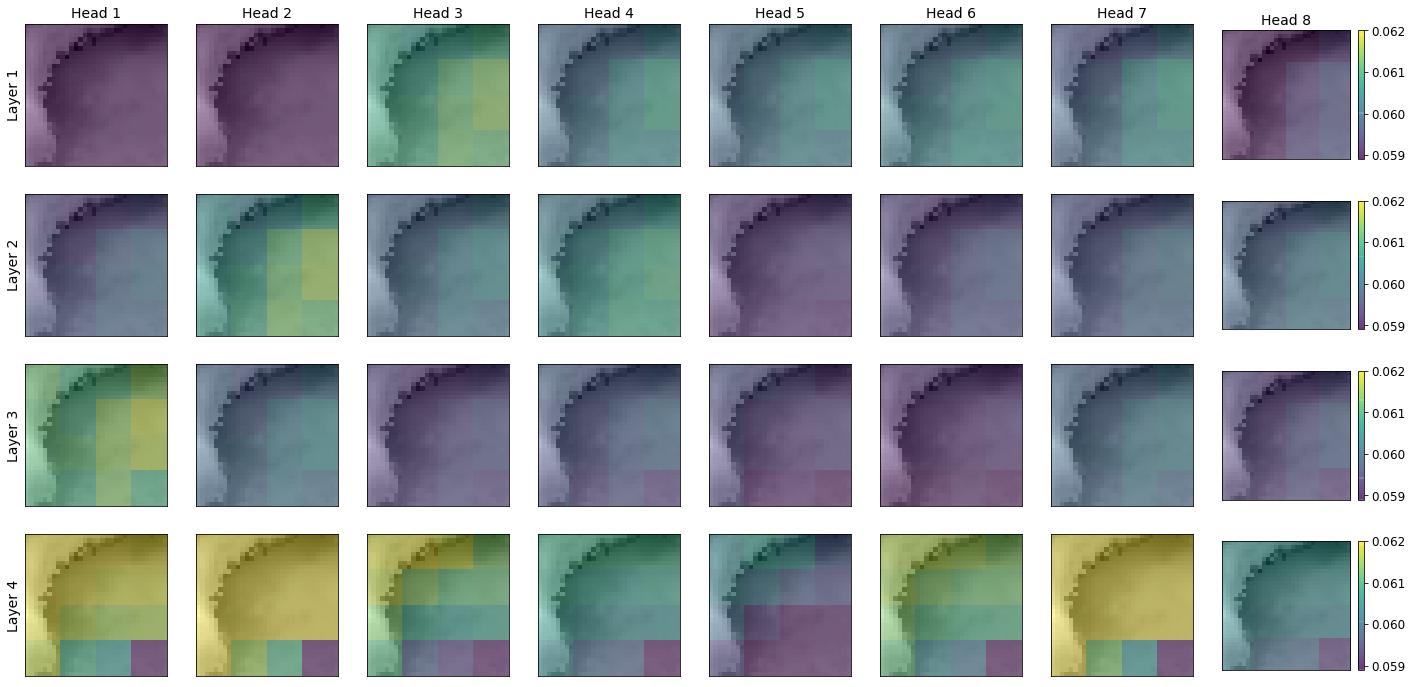

In [113]:
_ = engine.attention_map_visualize(list_output[0], list_inputs[0], list_attention_maps[0], variable = 93, date = '20200115_0000')

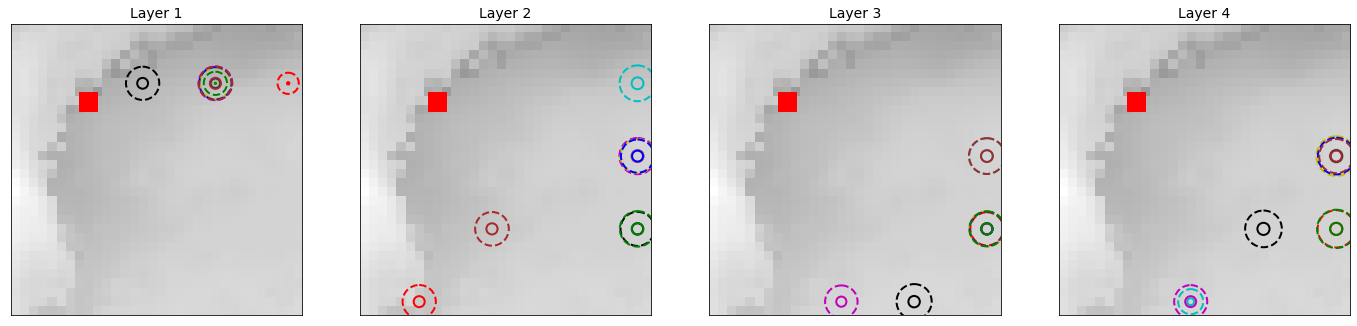

In [123]:
_ = engine.attention_map_guassian_visualize(list_output[0], list_inputs[0], list_attention_scores[0], variable = 93, date = '20200115_0000')